<a href="https://colab.research.google.com/github/RubberLanding/AdversarialMachineLearning24/blob/weight_perturbation/adversarial_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preliminaries


Install all needed packages.

In [1]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
project_dir = Path('/content/drive/MyDrive/adversarial_training')
project_dir.mkdir(parents=True, exist_ok=True)

import zipfile
import shutil

weight_dir = project_dir / "weights"
weight_dir.mkdir(parents=True, exist_ok=True)
weight_file = weight_dir / "resnet18.pt"

# """Extract the pre-trained model weights to Google Drive"""
# with zipfile.ZipFile("state_dicts.zip", "r") as zip_ref:
#   # print(zip_ref.namelist())
#   with zip_ref.open("state_dicts/resnet18.pt") as zf, open(weight_file, 'wb') as f:
#       shutil.copyfileobj(zf, f)

Mounted at /content/drive


In [2]:
!pip install torch
!pip install torchvision
!pip install git+https://github.com/fra31/auto-attack
!pip install statsmodels
# !git pull https://github.com/RubberLanding/AdversarialMachineLearning24

  Cloning https://github.com/fra31/auto-attack to /tmp/pip-req-build-fr08sspk
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack /tmp/pip-req-build-fr08sspk
  Resolved https://github.com/fra31/auto-attack to commit a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Preparing metadata (setup.py) ... done


Download the weights for the pre-trained Resnet18 on CIFAR-10. We only do this once and store them on a private GoogleDrive, which we later import to be able to actually load the weights.

In [4]:
# """Download pre-trained weights for ResNet18 on CIFAR10"""
# !pip install gdown

# # Source: https://github.com/huyvnphan/PyTorch_CIFAR10
# FILE_ID = "17fmN8eQdLpq2jIMQ_X0IXDPXfI9oVWgq"
# file_url = f"https://drive.google.com/uc?id={FILE_ID}"

# !gdown {file_url}

Import all packages und functions we need.

In [4]:
!pip install git+https://github.com/fra31/auto-attack

  Cloning https://github.com/fra31/auto-attack to /tmp/pip-req-build-wp_fd0i0
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack /tmp/pip-req-build-wp_fd0i0
  Resolved https://github.com/fra31/auto-attack to commit a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Preparing metadata (setup.py) ... done
  Created wheel for autoattack: filename=autoattack-0.1-py3-none-any.whl size=36229 sha256=32fc4db144b8c15e9c109f3aaeb730d46f878bfe5058a872deb48db5911e0282
  Stored in directory: /tmp/pip-ephem-wheel-cache-w7bwqxmp/wheels/b7/17/95/4b16fafe1b84fdabd247eb5f01b41165bd98d4c82d64ab93d2
Successfully built autoattack


In [5]:
import torch
import numpy as np
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

Mount your GoogleDrive where you stored the weights for the pre-trained Resnet18 before. We will also store the logging files and model weights there.

In [6]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
project_dir = Path('/content/drive/MyDrive/adversarial_training')
project_dir.mkdir(parents=True, exist_ok=True)

import zipfile
import shutil

weight_dir = project_dir / "weights"
weight_dir.mkdir(parents=True, exist_ok=True)
weight_file = weight_dir / "resnet18.pt"

# """Extract the pre-trained model weights to Google Drive"""
# with zipfile.ZipFile("state_dicts.zip", "r") as zip_ref:
#   with zip_ref.open("state_dicts/resnet18.pt") as zf, open(weight_file, 'wb') as f:
#       shutil.copyfileobj(zf, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define a convenience function to name the different training runs.

In [7]:
import random
from datetime import datetime

def generate_run_name():
    """Generate a random name for a run."""
    colors = [
        "red", "blue", "green", "yellow", "purple", "orange", "pink",
        "black", "white", "gray", "silver", "gold", "cyan", "magenta"]
    adjectives = [
        "fast", "slow", "shiny", "dull", "bright", "dark", "silent",
        "loud", "brave", "calm", "wise", "fierce", "kind", "strong"]
    nouns = [
        "dragon", "tiger", "lion", "panda", "wolf", "phoenix", "eagle",
        "fox", "bear", "shark", "hawk", "cheetah", "whale", "octopus"]
    color = random.choice(colors)
    adjective = random.choice(adjectives)
    noun = random.choice(nouns)

    timestamp = datetime.now().strftime("%Y%m%d-%H%M")
    run_name = f"{color}-{adjective}-{noun}-{timestamp}"
    return run_name

# Data
Download the CIFAR-10 data. Split it into training, validation and test set. Do some pre-processing.

In [8]:
batch_size = 1024 # batch size has to be < 2**16, should be <= 2**13 for T4
debug = True

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.491, 0.482, 0.446], std=[0.247, 0.243, 0.261]),
    ])

""" Load data """
data_train = CIFAR10(root="datasets", train=True, download=True, transform=transform)
data_test = CIFAR10(root="datasets", train=False, download=True, transform=transform)
data_test, data_val = torch.utils.data.random_split(data_test, [0.1, 0.9])

dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=len(data_test), shuffle=False) # create test dataloader with a single batch
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)

num_classes = len(data_train.classes)

# mean = data_train.data.mean(axis=(0,1,2)) / 255 # [0.49139968, 0.48215841, 0.44653091]
# std = data_train.data.std(axis=(0,1,2)) / 255 # [0.24703223, 0.24348513, 0.26158784]

data_train_subset = Subset(data_train, list(range(2*batch_size)))
data_val_subset = Subset(data_val, list(range(10)))
data_test_subset = Subset(data_test, list(range(100)))

dataloader_train_subset = DataLoader(data_train_subset, batch_size=batch_size, shuffle=True)
dataloader_val_subset = DataLoader(data_val_subset, batch_size=len(data_val_subset), shuffle=False)
dataloader_test_subset = DataLoader(data_test_subset, batch_size=len(data_test_subset), shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified


# Attacks
Define the attacks.

In [9]:
import torch.nn.functional as F

def fgsm(model, X, y, epsilon=8/255):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=8/255, alpha=2/255, num_iter=10, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

def pgd_linf_trades(model, X, y, epsilon=8/255, alpha=2/255, num_iter=10, randomize=False):
    """ Construct FGSM adversarial examples with KL-Divergence for TRADES.
        Should be used together with traded_loss().
    """
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        # maybe set log_target=True and pass F.log_softmax(model(X), dim=1),
        # see the docs for more details
        loss = F.kl_div(F.log_softmax(model(X + delta), dim=1),
                        F.softmax(model(X), dim=1),
                        reduction='batchmean')
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()


# Losses
We define a wrapper, that calls the appropriate loss function with the correct arguments. Inside the wrapper, we implement the loss functions.

In [10]:
class LossWrapper:
    def __init__(self, loss_fn, lambda_tradeoff=1.0):
        self.loss_fn = loss_fn
        self.lambda_tradeoff = lambda_tradeoff

    def __call__(self, model, X, y, delta=0.0):
        """Args:
              model: The model being trained.
              X: Clean input data.
              delta: Perturbations applied to X.
              y: Ground-truth labels.
        """
        # Cross-Entropy Loss
        if self.loss_fn == "CE":
            yp = model(X + delta)
            return F.cross_entropy(yp, y)

        # TRADES Loss
        elif self.loss_fn == "TRADES":
            yp_adv = model(X + delta)
            yp_clean = model(X)
            clean_loss = F.cross_entropy(yp_clean, y)
            robust_loss = F.kl_div(F.log_softmax(yp_adv, dim=1),
                            F.softmax(yp_clean, dim=1),
                            reduction='batchmean')
            return clean_loss + self.lambda_tradeoff * robust_loss

        else:
            raise ValueError("Unsupported loss function")

# Training

Define functions that train a model.

In [11]:
def train_epoch(loader, model, opt, loss_fn):
    """Standard training/evaluation epoch over the dataset"""
    model.train()
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = loss_fn(model, X, y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

@torch.no_grad()
def eval_epoch(loader, model, loss_fn):
    """Standard training/evaluation epoch over the dataset"""
    model.eval()
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = loss_fn(model, X, y)
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def train_epoch_adversarial(loader, model, attack, opt, loss_fn, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    model.train()
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = loss_fn(model, X, y, delta)
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def eval_epoch_adversarial(loader, model, attack, loss_fn, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    model.eval()  # Set the model to evaluation mode
    total_loss, total_err = 0.0, 0.0

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        # Compute adversarial perturbations (requires gradients)
        with torch.enable_grad():
            delta = attack(model, X, y, **kwargs)

        # Evaluate the model on adversarial examples without gradients
        with torch.no_grad():
            yp = model(X + delta)
            loss = loss_fn(model, X, y, delta)

            total_err += (yp.max(dim=1)[1] != y).sum().item()
            total_loss += loss.item() * X.shape[0]

    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def train_epoch_rs(loader, model, opt, loss_fn, sigma=0.25):
    """Training epoch with Gaussian noise over the dataset for Randomized Smoothing"""
    model.train()
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X + torch.randn_like(X) * sigma) # Add Gaussian noise
        loss = loss_fn(model, X, y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

@torch.no_grad()
def eval_epoch_rs(loader, model, loss_fn, sigma=0.25):
    """Standard training/evaluation epoch over the dataset"""
    model.eval()
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X + torch.randn_like(X) * sigma)
        loss = loss_fn(model, X, y)
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def train_epoch_awp(loader, model, attack, opt, loss_fn, awp, **kwargs):
    """Adversarial Weight Perturbation training/evaluation epoch over the dataset"""
    model.train()
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)

        #Perform AWP attack before forwad pass
        awp.attack_backward(X, y) # Apply perturbation

        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = loss_fn(model, X, y, delta)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]

    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

# Models

In [11]:
# Evaluation Functions

import json
import matplotlib.pyplot as plt
import io
import contextlib
from autoattack import AutoAttack
import torch
from torch.nn import CrossEntropyLoss, Conv2d
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

# Sanity Check: Loading the log file and plotting adversarial accuracies over training epochs
def sanity_check(model_name):
  project_dir = Path('/content/drive/MyDrive/adversarial_training')
  with open(project_dir / model_name / "log.json", "r") as f:
      log = json.load(f)

  plt.plot(np.ones_like(log['adv_errors']) - log["adv_errors"])
  plt.xlabel("Epoch")
  plt.ylabel("Robust Accuracy")
  return None

# Evaluate Baseline Robust Accuracy and Final Robust Accuracy (after training) of a Model
def evaluate_robust_accuracy(model_name, dataloader, attack):
    model = resnet18()
    model.conv1 = Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.eval()
    model = model.to(device)
    baseline_robust_accuracy = 1 - eval_epoch_adversarial(dataloader, model, attack, loss_fn=LossWrapper("CE"))[0]

    weight_file = project_dir / model_name / "model_adv.pt"
    # load weight file to evaluate trained model
    model.load_state_dict(torch.load(weight_file, weights_only=True))
    model = model.to(device)
    model.eval()
    final_robust_accuracy = 1 - eval_epoch_adversarial(dataloader, model, attack, loss_fn=LossWrapper("CE"))[0]
    print(f"Baseline Robust Accuracy: {baseline_robust_accuracy}")
    print(f"Final Robust Accuracy: {final_robust_accuracy}")
    return baseline_robust_accuracy, final_robust_accuracy

def evaluate(weight_file, dataloader, attack):
    model = resnet18()
    model.conv1 = Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.eval()
    model.load_state_dict(torch.load(weight_file, weights_only=True))
    model = model.to(device)
    clean_accuracy = 1 - eval_epoch(dataloader, model, loss_fn=LossWrapper("CE"))[0]
    if attack == 'fgsm':
        robust_accuracy = 1 - eval_epoch_adversarial(dataloader, model, fgsm, loss_fn=LossWrapper("CE"))[0]
    elif attack == 'pgd':
      robust_accuracy = 1 - eval_epoch_adversarial(dataloader, model, pgd_linf, loss_fn=LossWrapper("CE"))[0]
    elif attack == 'autoattack':
        x_test, y_test = next(iter(dataloader))
        x_test, y_test = x_test.to(device), y_test.to(device)
        output_buffer = io.StringIO()
        with contextlib.redirect_stdout(output_buffer):
            adversary = AutoAttack(model_adv, norm='Linf', eps=8/255, version='standard', device=device)
            adversary.run_standard_evaluation(x_test, y_test, bs=128)

        output = output_buffer.getvalue()

        lines = output.splitlines()
        for line in reversed(lines):
            if "robust accuracy:" in line.lower():
                robust_acc = float(line.split(":")[-1].strip().replace("%", "")) / 100.0
                break
        else:
            robust_acc = None
    return clean_accuracy, robust_accuracy


Baseline Robust Accuracy: 0.010000000000000009
Final Robust Accuracy: 0.69


(0.010000000000000009, 0.69)

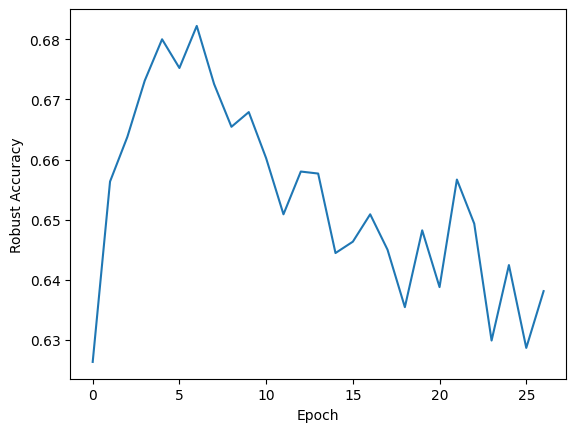

In [14]:
# Sanity Checks
model = 'adversarial_training'
sanity_check(model)

evaluate_robust_accuracy(model, dataloader_test_subset, fgsm)

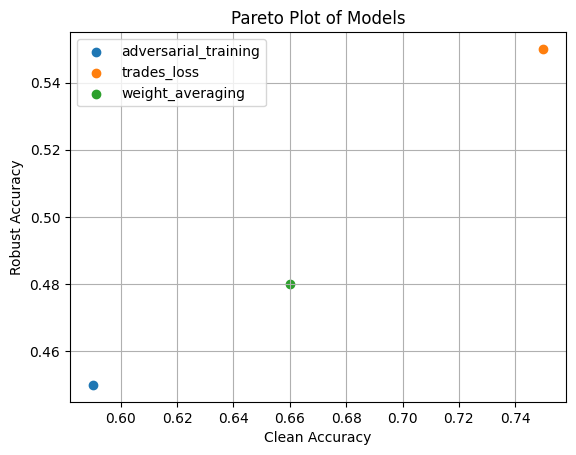

In [ ]:
# Pareto plot of all models

models_to_evaluate = ['adversarial_training','trades_loss','weight_averaging']
clean_accuracies = []
robust_accuracies = []
# for plotting
handles = []

for model in models_to_evaluate:
    weight_file = project_dir / model / "model_adv.pt"
    attack = 'fgsm'
    dataloader_test = dataloader_test_subset

    clean_accuracy, robust_accuracy = evaluate(weight_file, dataloader_test, attack)
    clean_accuracies.append(clean_accuracy)
    robust_accuracies.append(robust_accuracy)
    handle = plt.scatter(clean_accuracy, robust_accuracy, label=model)
    handles.append(handle)

plt.xlabel('Clean Accuracy')
plt.ylabel('Robust Accuracy')
plt.title('Pareto Plot of Models')
plt.legend(handles=handles)
plt.grid(True)
plt.show()

# Adversarial Weight Perturbation

Instead of perturbing on the input-loss landscape, this method perturbs the weight space during training, making it more robust to adversarial gradients. As a consequence the loss landscape becomes smoother. This makes it harder for PGD and FGSM types of attacks to find steepness in the loss landscape.

## Setting up the Model


In [12]:
import json
from torch.nn import CrossEntropyLoss, Conv2d

###########################
# LOAD THE MODEL

model_adv = resnet18()

# CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
model_adv.conv1 = Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_adv.fc = torch.nn.Linear(model_adv.fc.in_features, num_classes)

pretrained_weights = torch.load(weight_file, weights_only=True)
model_adv.load_state_dict(pretrained_weights)
model_adv = model_adv.to(device)

###########################
# SET LOGGING

run_dir = project_dir / 'adversarial_weight_perturbation_with_trades'
run_dir.mkdir(parents=True, exist_ok=True)
log = {key: [] for key in ["train_losses", "test_losses", "adv_losses",
                           "train_errors", "test_errors", "adv_errors"]}


## Adversarial Weight Perturbation functions

We define a function that takes a model and a datapoint, computes the weights for that data points and then perturbs it with a magnitude of epsilon and the sign of the gradient to maximise the loss. There is an inner optimization loop that finds the worst-case weight perturbation. The number of steps is a hyperparameter.

We also define training and validation functions. We can use these functions to integrate AWP into a regular adversarial training loop.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AWP(object):
    def __init__(self, model, optimizer, adv_param="weight", adv_lr=0.01, adv_eps=5e-3):
        self.model = model
        self.optimizer = optimizer
        self.adv_param = adv_param
        self.adv_lr = adv_lr
        self.adv_eps = adv_eps
        self.backup = {}
        self.grad_backup = {}

    def attack_backward(self, x, y):
        """
        This is the function to call to execute the attack.
        It will update the model weights in-place.
        """
        if self.adv_param == "weight":
            self._save()  # Save model weights before perturbation
            self._attack_step()  # Perform adversarial weight perturbation
        elif self.adv_param == "gradient":
            self._attack_step_grad()  # Perform adversarial gradient perturbation
        else:
            raise ValueError(f"Invalid adv_param: {self.adv_param}")

        # Calculate loss with perturbed weights
        loss = F.cross_entropy(self.model(x), y)

        # Update model parameters
        self.optimizer.zero_grad()  # Reset gradients before backward pass
        loss.backward()
        self.optimizer.step()  # Update model weights

        if self.adv_param == "weight":
            self._restore()  # Restore original model weights

    def _attack_step(self):
        e = 1e-6
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                norm1 = torch.norm(param.grad)
                norm2 = torch.norm(param.data.detach())
                if norm1 != 0 and norm2 != 0:
                    r_at = self.adv_lr * param.grad / (norm1 + e) * (norm2 + e)
                    param.data.add_(r_at)
                    param.data = torch.min(
                        torch.max(param.data, self.backup[name] - self.adv_eps),
                        self.backup[name] + self.adv_eps,
                    )

    def _attack_step_grad(self):
        e = 1e-6
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                # Compute the adversarial gradient perturbation
                # Here, it's a simple scaled version of the gradient
                r_at = self.adv_lr * param.grad

                # Add the perturbation to the gradient
                param.grad.add_(r_at)

                # Optional: Clipping the gradient
                # torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

    def _save(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                if name not in self.backup:
                    self.backup[name] = param.data.clone()
                    self.grad_backup[name] = param.grad.clone()

    def _restore(self):
        for name, param in self.model.named_parameters():
            if name in self.backup:
                param.data.copy_(self.backup[name])

## Train the Adversarial Weight Perturbation model

In [14]:
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

opt = Adam(model_adv.parameters(), lr=1e-3, weight_decay=5e-4)
# opt = SGD(model_adv.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4,nesterov=False)

# scheduler = CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, eta_min=0)
epochs = 200
scheduler = CosineAnnealingLR(opt, T_max=epochs,eta_min=1e-6)
epsilon = 5e-3
num_steps = 1
trades = LossWrapper("TRADES")
cross_entropy = LossWrapper("CE")

# Create instance of AWP class
awp = AWP(model_adv,opt)

log = {key: [] for key in ["train_losses", "test_losses", "adv_losses",
                           "train_errors", "test_errors", "adv_errors"]}

print(f"Begin adversarial training run: {run_dir.stem}\n")
print(*("TR      ", "TE      ", "ADV     ", "Epoch   "), sep="\t")

for epoch in range(epochs):
  train_err, train_loss = train_epoch_awp(dataloader_train, model_adv, pgd_linf_trades, loss_fn=trades, awp=awp, opt=opt)
  test_err, test_loss = eval_epoch(dataloader_val, model_adv, loss_fn=cross_entropy)
  adv_err, adv_loss = eval_epoch_adversarial(dataloader_val, model_adv, fgsm, loss_fn=cross_entropy)

  scheduler.step()
  log["train_losses"] += [train_loss]
  log["test_losses"] += [test_loss]
  log["adv_losses"] += [adv_loss]
  log["train_errors"] += [train_err]
  log["test_errors"] += [test_err]
  log["adv_errors"] += [adv_err]

  print(*("{:.6f}".format(train_err),
          "{:.6f}".format(test_err),
          "{:.6f}".format(adv_err),
          f"{epoch+1}",), sep="\t")

  ###########################
# STORE RESULTS
store = True # set this variable to True when you have runs that you want to save
if store:
  with open(run_dir / "log.json", "w") as f:
      json.dump(log, f)
  torch.save(model_adv.state_dict(), run_dir / "model_adv.pt")


Begin adversarial training run: adversarial_weight_perturbation_with_trades

TR      	TE      	ADV     	Epoch   


KeyboardInterrupt: 

## Setup the Advarsarial Training Model


In [15]:
import json
from torch.nn import CrossEntropyLoss, Conv2d

###########################
# LOAD THE MODEL

model_adv = resnet18()

# CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
model_adv.conv1 = Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_adv.fc = torch.nn.Linear(model_adv.fc.in_features, num_classes)

pretrained_weights = torch.load(weight_file, weights_only=True)
model_adv.load_state_dict(pretrained_weights)
model_adv = model_adv.to(device)

###########################
# SET LOGGING

run_dir = project_dir / 'adversarial_training'
run_dir.mkdir(parents=True, exist_ok=True)
log = {key: [] for key in ["train_losses", "test_losses", "adv_losses",
                           "train_errors", "test_errors", "adv_errors"]}


## Train the Adversarial Training Model
Use adversarial training to train the robust model.

In [ ]:
###########################
# SET TRAINING PARAMETERS

# opt = Adam(model_adv.parameters(), lr=1e-3, weight_decay=4e-3)
opt = SGD(model_adv.parameters(), lr=1e-2, weight_decay=4e-3)
# scheduler = CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, eta_min=0)

epochs = 200

scheduler = CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-6)
patience = 0.005
training_error_threshold = 0.01

trades = LossWrapper("TRADES")
cross_entropy = LossWrapper("CE")
###########################
# START TRAINING

print(f"Begin adversarial training run: {run_dir.stem}\n")
print(*("TR      ", "TE      ", "ADV     ", "Epoch   "), sep="\t")

for t in range(epochs):
    train_err, train_loss = train_epoch_adversarial(dataloader_train, model_adv, pgd_linf, opt, loss_fn=cross_entropy, randomize=True)
    test_err, test_loss = eval_epoch(dataloader_val, model_adv, loss_fn=cross_entropy)
    adv_err, adv_loss = eval_epoch_adversarial(dataloader_val, model_adv, fgsm, loss_fn=cross_entropy)

    # Stopping criterion
    if (t > 2) and ((log['adv_errors'][-1] - adv_err) < patience) and (train_err<training_error_threshold):
        print(f"Early stopping at epoch {t+1} due to insufficient improvement in adversarial ")
        break

    # Update the losses and errors
    log["train_losses"] += [train_loss]
    log["test_losses"] += [test_loss]
    log["adv_losses"] += [adv_loss]
    log["train_errors"] += [train_err]
    log["test_errors"] += [test_err]
    log["adv_errors"] += [adv_err]

    print(*("{:.6f}".format(train_err),
            "{:.6f}".format(test_err),
            "{:.6f}".format(adv_err),
            f"{t+1}",), sep="\t")

###########################
# STORE RESULTS
store = True # set this variable to True when you have runs that you want to save
if store:
  with open(run_dir / "log.json", "w") as f:
      json.dump(log, f)
  torch.save(model_adv.state_dict(), run_dir / "model_adv.pt")

Begin adversarial training run: adversarial_training

TR      	TE      	ADV     	Epoch   
0.347800	0.109889	0.307889	1
0.263280	0.109889	0.302889	2
0.232680	0.105000	0.285333	3
0.208060	0.104444	0.287889	4
0.187620	0.105222	0.285000	5
0.166780	0.101000	0.277333	6
0.150220	0.111556	0.297778	7
0.132580	0.103778	0.280778	8
0.121640	0.113111	0.284222	9
0.108380	0.136111	0.325889	10
0.093200	0.133444	0.316111	11


## Setup the Weight Averaging Model
Here we initialize an exponential moving average (EMA) model, based on the robust model.

In [ ]:
import json
from torch.nn import CrossEntropyLoss, Conv2d

###########################
# LOAD THE MODEL

model_adv = resnet18()

# CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
model_adv.conv1 = Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_adv.fc = torch.nn.Linear(model_adv.fc.in_features, num_classes)

pretrained_weights = torch.load(weight_file, weights_only=True)
model_adv.load_state_dict(pretrained_weights)

model_ema = torch.optim.swa_utils.AveragedModel(model_adv, multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(0.9))

model_adv = model_adv.to(device)
model_ema = model_ema.to(device)

###########################
# SET LOGGING

run_dir = project_dir / 'weight_averaging'
run_dir.mkdir(parents=True, exist_ok=True)
log = {key: [] for key in ["train_losses", "test_losses", "adv_losses",
                           "train_errors", "test_errors", "adv_errors"]}


# Train the Weight Averaged Model

In [ ]:
###########################
# SET TRAINING PARAMETERS

opt = Adam(model_adv.parameters(), lr=1e-3, weight_decay=4e-3)
# opt = SGD(model_adv.parameters(), lr=1e-1)
# scheduler = CosineAnnealingLR(opt, T_max=100)
# scheduler = CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, eta_min=0)

epochs = 200
patience = 0.005
training_error_threshold = 0.01

trades = LossWrapper("TRADES")
cross_entropy = LossWrapper("CE")

###########################
# START TRAINING

print(f"Begin adversarial training run: {run_dir.stem}\n")
print(*("TR      ", "TE      ", "ADV     ", "Epoch   "), sep="\t")

for t in range(epochs):
    train_err, train_loss = train_epoch_adversarial(dataloader_train, model_adv, pgd_linf, opt, loss_fn=cross_entropy, randomize=True)
    model_ema.update_parameters(model_adv) # Update EMA model

    test_err, test_loss = eval_epoch(dataloader_val, model_ema, loss_fn=cross_entropy) # Evaluate clean acc. on EMA model
    adv_err, adv_loss = eval_epoch_adversarial(dataloader_val, model_ema, fgsm, loss_fn=cross_entropy) # Evaluate robust acc. on EMA model

    # Stopping criterion
    if (t > 2) and ((log['adv_errors'][-1] - adv_err) < patience) and (train_err<training_error_threshold):
        print(f"Early stopping at epoch {t+1} due to insufficient improvement in adversarial ")
        break

    # Update the losses and errors
    log["train_losses"] += [train_loss]
    log["test_losses"] += [test_loss]
    log["adv_losses"] += [adv_loss]
    log["train_errors"] += [train_err]
    log["test_errors"] += [test_err]
    log["adv_errors"] += [adv_err]

    print(*("{:.6f}".format(train_err),
            "{:.6f}".format(test_err),
            "{:.6f}".format(adv_err),
            f"{t+1}",), sep="\t")

###########################
# STORE RESULTS
store = False # set this variable to True when you have runs that you want to save
if store:
  with open(run_dir / "log.json", "w") as f:
      json.dump(log, f)
  torch.save(model_adv.state_dict(), run_dir / "model_adv.pt")
  torch.save(model_ema.state_dict(), run_dir / "model_ema.pt")

Begin adversarial training run: weight_averaging

TR      	TE      	ADV     	Epoch   
0.752930	0.890625	0.897461	1
0.795410	0.725586	0.802734	2
0.688965	0.882812	0.892578	3
0.656250	0.891602	0.899414	4
0.634766	0.901367	0.901367	5
0.602051	0.901367	0.901367	6
0.576660	0.901367	0.901367	7
0.562012	0.900391	0.901367	8
0.538086	0.881836	0.889648	9
0.521973	0.809570	0.838867	10
0.502930	0.740234	0.783203	11
0.469727	0.692383	0.742188	12
0.452637	0.687500	0.728516	13
0.415527	0.671875	0.725586	14
0.384766	0.652344	0.715820	15
0.358887	0.602539	0.681641	16
0.334961	0.575195	0.660156	17
0.293457	0.517578	0.620117	18
0.267578	0.516602	0.617188	19
0.248047	0.486328	0.590820	20
0.213867	0.474609	0.587891	21
0.173828	0.470703	0.583008	22
0.167480	0.479492	0.583984	23
0.160645	0.467773	0.591797	24
0.117676	0.458008	0.574219	25
0.131348	0.442383	0.571289	26
0.102539	0.440430	0.570312	27
0.065430	0.434570	0.557617	28
0.037598	0.413086	0.551758	29
0.033203	0.426758	0.569336	30


# Randomized Smoothing

Define a RandomizerSmoother. This class takes a base model and uses it to perform Randomized Smoothing. In theory, this allows to get certified robustness guarantees for any classifier.   

In [ ]:
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm, binomtest

class RandomizedSmoother(object):

  def __init__(self, base_model, num_classes, sigma=0.25, epsilon=8/255, alpha=0.05, norm="L2"):
    self.base_model = base_model
    self.num_classes = num_classes
    self.sigma = sigma
    self.epsilon = epsilon
    self.norm = norm
    self.alpha = alpha

  def predict(self, X, num_samples=100):
    batch_size = X.size(0)
    # Compute class counts for noisy samples
    class_counts = self.get_noisy_counts(X, num_samples)

    # Sort class counts to find top 2 most frequent classes
    sorted_counts_vals, sorted_counts_ind = class_counts.sort()
    top1_class = sorted_counts_ind[:, -1]  # Most frequent class
    top2_class = sorted_counts_ind[:, -2]  # Second most frequent class
    top1_class_count = sorted_counts_vals[:, -1]
    top2_class_count = sorted_counts_vals[:, -2]

    predictions = torch.zeros(batch_size, device=X.device)
    for i in range(batch_size):
        # Use binomial test to check if the top class is significantly more frequent
        n_a, n_b = top1_class_count[i], top2_class_count[i]
        predictions[i] = top1_class[i] if binomtest(n_a, n_a + n_b, p=0.5).pvalue <= self.alpha else float('nan')

    return predictions

  def certify(self, X, num_samples_selection=100, num_samples_estimation=100):
    batch_size = X.size(0)
    # Perform two sampling procedures to avoid selection bias
    counts_a = self.get_noisy_counts(X, num_samples_selection)
    top1_class = counts_a.argmax(dim=-1).unsqueeze(1)  # Get most frequent class index

    counts = self.get_noisy_counts(X, num_samples_estimation)
    # Extract the counts for the most frequent class
    n_a = counts.gather(dim=1, index=top1_class).squeeze()

    certified_radii = torch.zeros(batch_size)
    predictions = torch.zeros(batch_size, device=X.device)
    for i in range(batch_size):
        # Compute lower confidence bound for the top class probability
        conf_bound, _ = proportion_confint(n_a[i], num_samples_estimation, alpha=2 * self.alpha, method="beta")
        # Calculate the certified radius based on the confidence bound
        if conf_bound >= 0.5:
          certified_radii[i] = self.get_radius(conf_bound, self.norm)
          predictions[i] = top1_class[i]
        else:
          certified_radii[i] = float("nan")
          predictions[i] = float("nan")

    return certified_radii, predictions

  def get_noisy_counts(self, X, num_samples):
    batch_size = X.size(0)
    class_counts = torch.zeros(batch_size, self.num_classes, dtype=torch.int64, device=X.device)

    for _ in range(num_samples):
        # Generate noisy samples based on the specified norm
        noisy_samples = X + self.get_noise(X.shape, self.norm)
        with torch.no_grad():
            # Predict classes for noisy samples
            logits = self.base_model(noisy_samples)
            class_pred = F.softmax(logits, dim=-1).argmax(dim=-1)
            # Update class counts
            for i in range(batch_size):
                class_counts[i, class_pred[i]] += 1

    return class_counts

  def get_noise(self, shape, p_norm="L2"):
    if p_norm=="L2":
      return torch.randn(shape) * self.sigma
    elif p_norm=="Linf":
      return 2 * self.epsilon * torch.rand(shape) - self.epsilon
    else:
      raise ValueError("Unsupported norm.")

  def get_radius(self, conf_bound, p_norm="L2"):
    if p_norm=="L2":
      return self.sigma * norm.ppf(conf_bound)
    elif p_norm=="Linf":
      return self.epsilon * (2 * conf_bound - 1)
    else:
      raise ValueError("Unsupported norm.")

We load the regular model with pre-trained weights and a model that was adversarially trained with the TRADES loss.

In [ ]:
import json
from torch.nn import CrossEntropyLoss, Conv2d

###########################
# LOAD THE MODEL

def get_resnet18():
  model = resnet18()
  # CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
  model.conv1 = Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
  model.fc = torch.nn.Linear(model.fc.in_features, 10)
  return model

model_base = get_resnet18()
pretrained_weights = torch.load(weight_file, weights_only=True)
model_base.load_state_dict(pretrained_weights)
model_base = model_base.to(device)

model_trades = get_resnet18()
pretrained_weights_trades = torch.load(weight_dir / "resnet18_trades.pt", weights_only=True, map_location=torch.device('cpu'))
model_trades.load_state_dict(pretrained_weights_trades)
model_trades = model_trades.to(device)

X, y = next(iter(dataloader_val_subset)) # Loader should be single batch containing all the data
X, y = X.to(device), y.to(device)

We define a function that calculates the certified accuracy in dependence on the radius. This means, that for each sample in the dataset, we check whether its radius is higher than the reference value for the radius. If so, we include it in our calculation for the accuracy.

In [ ]:
import matplotlib.pyplot as plt

np.set_printoptions(threshold=100)

def calculate_certified_acc(radius, yp, y, num_bins=1000):
  num_samples = len(y)
  ind_not_nan = ~torch.isnan(radius)
  radius, yp, y = radius[ind_not_nan], yp[ind_not_nan], y[ind_not_nan] # Filter out entries with NaN
  max_val = radius.max()
  bins = torch.linspace(0.0, max_val, num_bins + 1)
  counts = np.array([(yp[radius > bin_value] == y[radius > bin_value]).sum() for bin_value in bins])
  acc = counts / num_samples

  return bins, acc

def plot_certified_acc(model_base, X, y, num_classes=10, epsilon=8/255, alpha=0.05):
  num_samples_estimation = 200
  num_samples_selection = 100
  sigmas = [0.1, 0.25, 0.5]

  n_sigma = len(sigmas)
  cmap = plt.get_cmap("viridis", n_sigma)
  colors = [cmap(i) for i in range(n_sigma)]

  for i, sigma in enumerate(sigmas):
    color = colors[i]
    model_rs = RandomizedSmoother(model_base, num_classes, sigma, epsilon, alpha)
    radius, yp = model_rs.certify(X, num_samples_selection, num_samples_estimation)

    # Check if radius has any non-NaN values before calling max()
    if torch.isnan(radius).all():
        print(f"Warning: All radii are NaN for sigma={sigma}. Skipping plotting.")
        continue  # Skip plotting if all radii are NaN
    x_radius, y_acc = calculate_certified_acc(radius, yp, y)
    plt.plot(x_radius, y_acc, label=f"sigma={sigma}", color=color, linewidth=1)

  plt.legend()
  plt.show()

In [ ]:
plot_certified_acc(model_base, X, y)

In [ ]:
plot_certified_acc(model_base, X, y)

# Regular Training

In [ ]:
#

In [ ]:
""" Regular Training """
import json
from torch.nn import CrossEntropyLoss, Conv2d

model_reg = resnet18()

# CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
model_reg.conv1 = Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_reg.fc = torch.nn.Linear(model_reg.fc.in_features, num_classes)

pretrained_weights = torch.load(weight_file, weights_only=True)
model_reg.load_state_dict(pretrained_weights)
model_reg = model_reg.to(device)

run_dir = project_dir / generate_run_name()
run_dir.mkdir(parents=True, exist_ok=True)

# opt = SGD(model_reg.parameters(), lr=1e-1)
opt = Adam(model_reg.parameters(), lr=1e-3)

epochs = 2
log = {key: [] for key in ["train_losses", "test_losses", "adv_losses",
                           "train_errors", "test_errors", "adv_errors"]}

print(f"Begin adversarial training run: {run_dir.stem}\n")
print(*("TR      ", "TE      ", "ADV     ", "     "), sep="\t")

for t in range(epochs):
    train_err, train_loss = train_epoch(dataloader_train, model_reg, opt)
    test_err, test_loss = eval_epoch(dataloader_test, model_reg)
    adv_err, adv_loss = eval_epoch_adversarial(dataloader_test, model_reg, fgsm)

    # Update the losses and errors
    log["train_losses"] += [train_loss]
    log["test_losses"] += [test_loss]
    log["adv_losses"] += [adv_loss]
    log["train_errors"] += [train_err]
    log["test_errors"] += [test_err]
    log["adv_errors"] += [adv_err]

    print(*("{:.6f}".format(train_err),
            "{:.6f}".format(test_err),
            "{:.6f}".format(adv_err),
            f"Epoch: {t+1}",), sep="\t")

with open(run_dir / "log.json", "w") as f:
    json.dump(log, f)
torch.save(model_reg.state_dict(), run_dir / "model_reg.pt")

In [ ]:
"""
ADV evaluated with FGSM
We observe that the ADV validation error is lower than the training error because FGSM is a weaker attack thatn PGD
Begin adversarial training run: magenta-slow-phoenix-20250105-1507

TR      	TE      	ADV     	Epoch
0.666760	0.406778	0.493000	1
0.539120	0.314444	0.405000	2
0.476300	0.274778	0.379000	3
0.432680	0.245222	0.339556	4
0.402620	0.230444	0.330000	5

ADV evaluated with PGD-Linf
We observe that the ADV validation error is higher than the training error as expected
Begin adversarial training run: orange-kind-shark-20250105-1531

TR      	TE      	ADV     	Epoch
0.675220	0.419667	0.599000	1
0.543500	0.310889	0.508778	2
0.472780	0.271000	0.475556	3
0.434380	0.248000	0.461889	4
0.403640	0.230444	0.457889	5
"""

In [ ]:
"""
gold-bright-eagle-20241204-1128:
SGD(lr=1e-1), batch_size=1024
"""
"""
orange-kind-hawk-20241204-1148:
SGD(lr=1e-1, weight_decay=5e-4), batch_size=1024
"""
"""
silver-shiny-phoenix-20241204-1210:
SGD(lr=1e-1, weight_decay=5e-4, momentum=0.9, nesterov=True), batch_size=1024
"""
"""
gray-fierce-octopus-20241204-1226:
SGD(lr=1e-1, weight_decay=5e-4, momentum=0.9, nesterov=True), batch_size=1024, CosineAnnealingLR
"""
"""
gold-loud-cheetah-20241204-1414:
SGD(lr=1e-1, weight_decay=5e-4, momentum=0.9, nesterov=True), batch_size=1024,, epsilon=4/255
"""
"""
cyan-wise-eagle-20241203-1710:
SGD(lr=1e-1, weight_decay=5e-4, momentum=0.9, nesterov=True), batch_size=1024,, epsilon=32/255
"""